In [1]:
import requests
import os
import zipfile
import pandas as pd
import re
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# Baixando arquivos

In [4]:
url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
url2 = "https://files.grouplens.org/datasets/movielens/ml-1m-README.txt"
local_filename = "ml-1m.zip"
local_readme = "ml-1m-README.txt"

In [3]:
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [5]:
with requests.get(url2, stream=True) as response:
    response.raise_for_status()
    with open(local_readme, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [13]:
extract_dir = os.path.dirname(os.path.abspath(local_filename))

In [14]:
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Manipulação de dados

In [2]:
file_path1 = "ml-1m/ratings.dat"
file_path2 = "ml-1m/movies.dat"

In [3]:
ratings = pd.read_csv(file_path1, sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
movies = pd.read_csv(file_path2, sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

In [5]:
movies['Genres'] = movies['Genres'].str.replace('|', ',')

In [8]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story (1995),"Animation,Children's,Comedy",1995
1,2,Jumanji (1995),"Adventure,Children's,Fantasy",1995
2,3,Grumpier Old Men (1995),"Comedy,Romance",1995
3,4,Waiting to Exhale (1995),"Comedy,Drama",1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [7]:
movies['Year'] = movies['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)

In [9]:
null_counts = movies.isnull().sum()
null_counts

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

In [10]:
null_counts = ratings.isnull().sum()
null_counts

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [11]:
num_users = ratings['UserID'].nunique()
num_users

6040

In [12]:
num_movies = movies['MovieID'].nunique()
num_movies

3883

In [13]:
df_genres = movies.copy()
df_genres = df_genres.drop('Genres', axis=1).join(movies['Genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))

/home/savio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


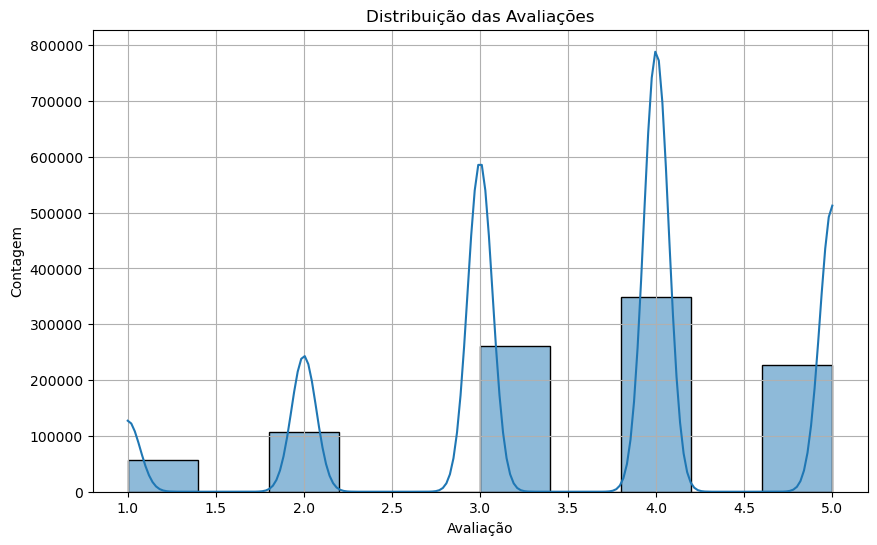

In [14]:
# 1. Distribuição das Avaliações
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Rating'], bins=10, kde=True)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

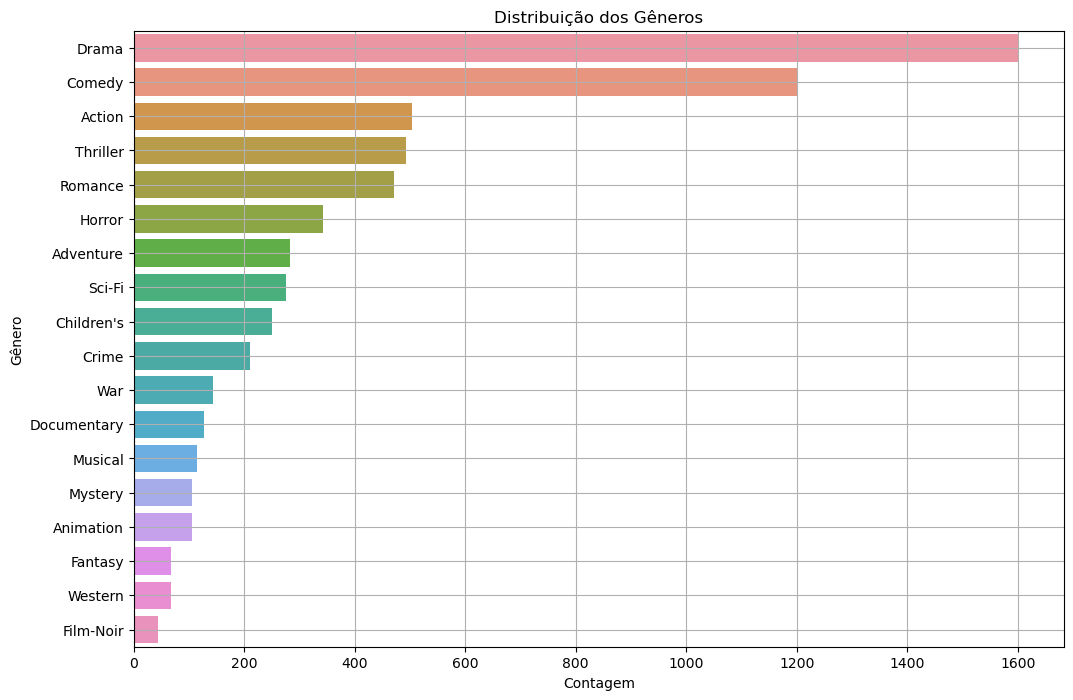

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Genre', data=df_genres, order = df_genres['Genre'].value_counts().index)
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.grid(True)
plt.show()

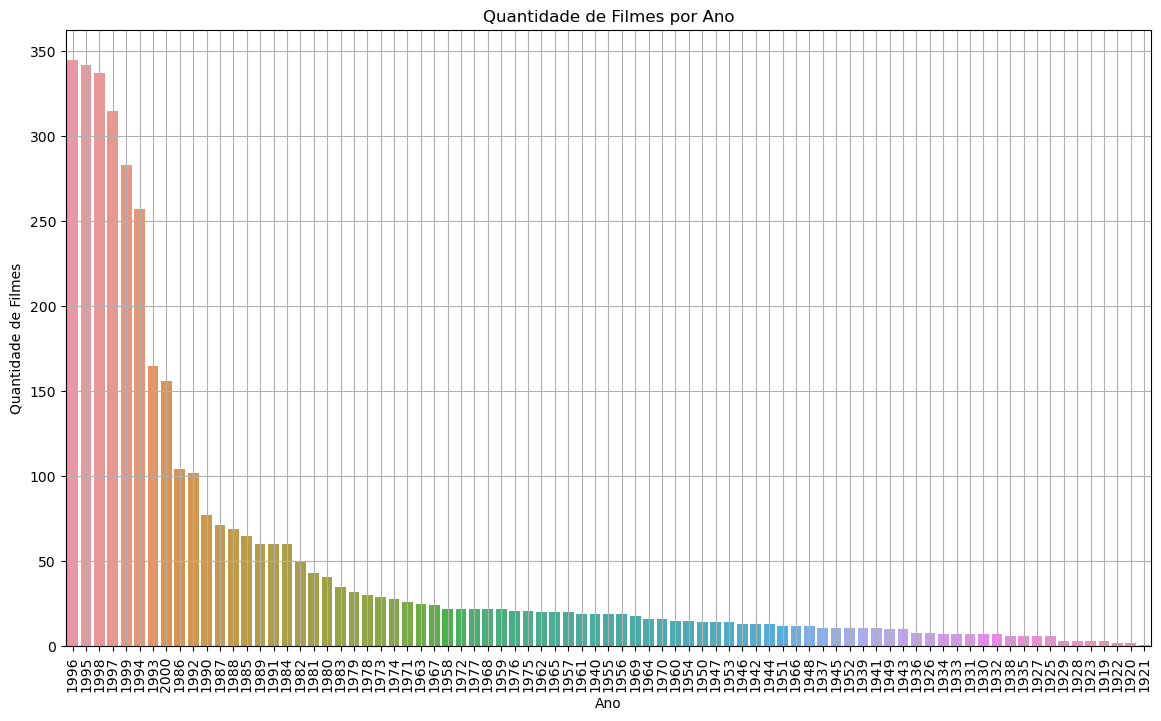

In [16]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Year', data=movies, order = movies['Year'].value_counts().index)
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Pré-processamento dos dados:

In [17]:
duplicated_ratings = ratings[ratings.duplicated()]

In [18]:
if not duplicated_ratings.empty:
    print("Valores duplicados encontrados:")
    print(duplicated_ratings)
else:
    print("Não há valores duplicados nas avaliações.")

Não há valores duplicados nas avaliações.


In [19]:
df_ratings = ratings.copy()

In [20]:
scaler = MinMaxScaler()
df_ratings[['Rating', 'Timestamp']] = scaler.fit_transform(df_ratings[['Rating', 'Timestamp']])
print("Dados de avaliações normalizados:\n", df_ratings.head())

Dados de avaliações normalizados:
    UserID  MovieID  Rating  Timestamp
0       1     1193    1.00   0.240631
1       1      661    0.50   0.240646
2       1      914    0.50   0.240645
3       1     3408    0.75   0.240626
4       1     2355    1.00   0.246465


# Matriz de distâncias

In [32]:
mlb = MultiLabelBinarizer()
genre_vectors = mlb.fit_transform(movies['Genres'])

In [33]:
distance_matrix = euclidean_distances(genre_vectors, genre_vectors)

In [34]:
distance_df = pd.DataFrame(distance_matrix, index=movies['MovieID'], columns=movies['MovieID'])

In [35]:
# Função para obter distâncias de um filme para todos os outros
def get_distances(movie_id, distance_df):
    if movie_id in distance_df.index:
        return distance_df.loc[movie_id]
    else:
        return pd.Series()

In [36]:
# Criar uma matriz de distância para as avaliações com base nos filmes
def create_ratings_distance_matrix(df_ratings, distance_df):
    num_ratings = len(df_ratings)
    ratings_distance_matrix = np.zeros((num_ratings, num_ratings))
    
    for i in range(num_ratings):
        for j in range(num_ratings):
            movie_id_i = df_ratings.iloc[i]['MovieID']
            movie_id_j = df_ratings.iloc[j]['MovieID']
            ratings_distance_matrix[i, j] = distance_df.loc[movie_id_i, movie_id_j]
    
    return ratings_distance_matrix


In [40]:
ratings_distance_matrix = create_ratings_distance_matrix(ratings, distance_df)

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000209, 1000209) and data type float64

Não consio criar a matriz dada a alta quantidade de avaliações.

# Criação de features

In [21]:
# Transformar os gêneros em listas de gêneros separados por vírgulas
movies['Genres'] = movies['Genres'].str.split(',')

In [22]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [23]:
mlb = MultiLabelBinarizer()
genre_vectors = mlb.fit_transform(movies['Genres'])

In [24]:
df_genres = pd.DataFrame(genre_vectors, columns=mlb.classes_, index=movies['MovieID'])

In [25]:
df_combined = df_ratings.join(df_genres, on='MovieID', how='left')

In [26]:
df_combined = df_combined.fillna(0)

In [27]:
print("Dados combinados:\n", df_combined.head().transpose())

Dados combinados:
                        0           1           2            3            4
UserID          1.000000    1.000000    1.000000     1.000000     1.000000
MovieID      1193.000000  661.000000  914.000000  3408.000000  2355.000000
Rating          1.000000    0.500000    0.500000     0.750000     1.000000
Timestamp       0.240631    0.240646    0.240645     0.240626     0.246465
Action          0.000000    0.000000    0.000000     0.000000     0.000000
Adventure       0.000000    0.000000    0.000000     0.000000     0.000000
Animation       0.000000    1.000000    0.000000     0.000000     1.000000
Children's      0.000000    1.000000    0.000000     0.000000     1.000000
Comedy          0.000000    0.000000    0.000000     0.000000     1.000000
Crime           0.000000    0.000000    0.000000     0.000000     0.000000
Documentary     0.000000    0.000000    0.000000     0.000000     0.000000
Drama           1.000000    0.000000    0.000000     1.000000     0.000000
Fantas

# Kmeans

In [28]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42}


In [88]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 81):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit(df_combined.drop(['UserID', 'MovieID'], axis=1))
   sse.append(kmeans.inertia_)

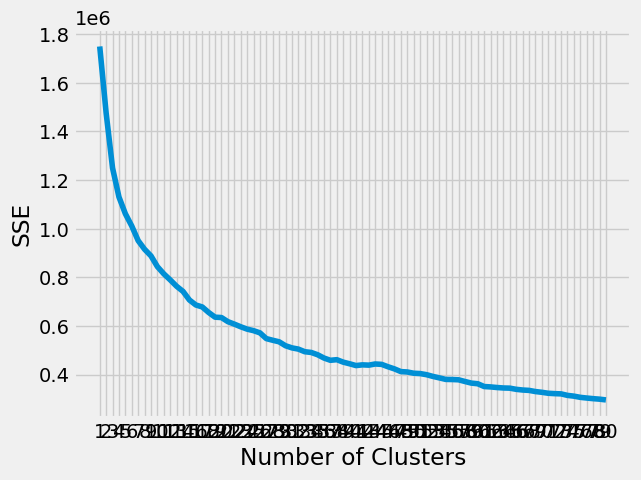

In [89]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 81), sse)
plt.xticks(range(1, 81))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [90]:
kl = KneeLocator(range(1, 81), sse, curve="convex", direction="decreasing")

In [91]:
kl.elbow

19

In [93]:
kmeans = KMeans(n_clusters=19, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(df_combined.drop(['UserID', 'MovieID'], axis=1))

In [94]:
ratings['KMeans_Cluster'] = kmeans_clusters
print("Clusters K-means:\n", ratings.head())

Clusters K-means:
    UserID  MovieID  Rating  Timestamp  KMeans_Cluster  DBSCAN_Cluster
0       1     1193       5  978300760               1               0
1       1      661       3  978302109              15              -1
2       1      914       3  978301968              14               0
3       1     3408       4  978300275               1               4
4       1     2355       5  978824291              13               2


In [95]:
cluster_counts = ratings['KMeans_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster
4     167048
1     160567
2      81115
5      60958
14     60625
7      60434
12     53761
11     52372
10     42925
3      42376
8      41671
16     34370
18     32614
13     22864
6      21112
15     20942
9      19919
0      19406
17      5130
Name: count, dtype: int64


# Clustering Hierárquico

In [86]:
agg_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg_clusters = agg_cluster.fit_predict(df_combined.drop(['UserID', 'MovieID', 'Timestamp'], axis=1))

/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


MemoryError: Unable to allocate 3.64 TiB for an array with shape (500208521736,) and data type float64

## DBscan

In [35]:
#minPts deve ser igual a  2x o número de features, logo =40
nbrs = NearestNeighbors(n_neighbors = 40).fit(df_combined)
neigh_dist, neigh_ind = nbrs.kneighbors(df_combined)

In [36]:
sort_neigh_dist = np.sort(neigh_dist, axis=0)

In [37]:
k_dist = sort_neigh_dist[:, 39]

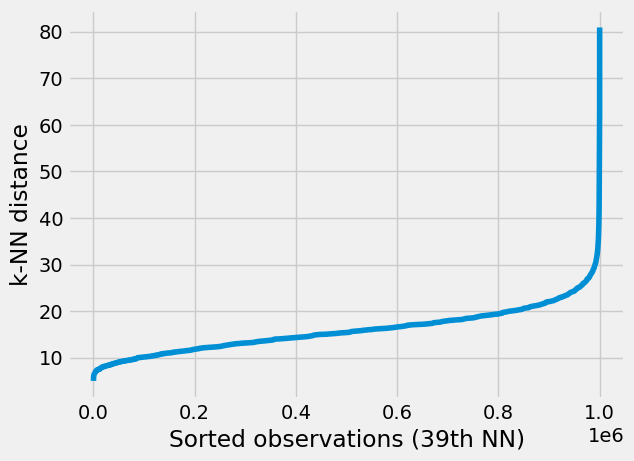

In [38]:
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (39th NN)")
plt.show()

In [103]:
eps = 21
min_samples = 40

In [104]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

In [105]:
dbscan_clusters = dbscan.fit_predict(df_combined)

In [106]:
ratings['DBSCAN_Cluster'] = dbscan_clusters
print("Clusters DBSCAN:\n", ratings.head())

Clusters DBSCAN:
    UserID  MovieID  Rating  Timestamp  KMeans_Cluster  DBSCAN_Cluster
0       1     1193       5  978300760               1               0
1       1      661       3  978302109              15              -1
2       1      914       3  978301968              14               0
3       1     3408       4  978300275               1               1
4       1     2355       5  978824291              13               1


In [107]:
len(ratings['DBSCAN_Cluster'].unique())

187

In [108]:
cluster_counts = ratings['DBSCAN_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 DBSCAN_Cluster
 0      569267
 1      379672
-1       28831
 120      1574
 143       763
         ...  
 70         17
 54         16
 126        14
 118        12
 153        10
Name: count, Length: 187, dtype: int64


In [109]:
ratings.to_csv('ratings_clustered.txt', sep='\t', index=False)

# Número de clusters

No Kmeans, verificou-se que ao aumentar o valor de k, não havia uma minimização tão ignificativa no SSE. De modo que os resultados possíveis podiam chegar em 80, e o valor ideal ficou por volta de 17.

Já utilizando o dbscan, pelo gráfico verificamos que por volta de 30 temos um ponto de inflexão, porém para valores de e maiores que 21 verificou-se um cluster monolito com mais de 900000 membros, portanto a maior distância que conseguiu remover esse cluster foi de 21. Para 20 tivemos um número excessivo de clusters, mais de 300.

# Análise dos clusters

Vamos tentar identificar os clusters dos filmes de terror e ficção científica

In [110]:
df_combined = ratings.merge(movies, on='MovieID', how='left')

In [111]:
print(df_combined.head())

   UserID  MovieID  Rating  Timestamp  KMeans_Cluster  DBSCAN_Cluster  \
0       1     1193       5  978300760               1               0   
1       1      661       3  978302109              15              -1   
2       1      914       3  978301968              14               0   
3       1     3408       4  978300275               1               1   
4       1     2355       5  978824291              13               1   

                                    Title                            Genres  \
0  One Flew Over the Cuckoo's Nest (1975)                           [Drama]   
1        James and the Giant Peach (1996)  [Animation, Children's, Musical]   
2                     My Fair Lady (1964)                [Musical, Romance]   
3                  Erin Brockovich (2000)                           [Drama]   
4                    Bug's Life, A (1998)   [Animation, Children's, Comedy]   

   Year  
0  1975  
1  1996  
2  1964  
3  2000  
4  1998  


In [112]:
generos_unicos = set()
for generos in movies['Genres']:
    for genero in generos:
        generos_unicos.add(genero)

In [113]:
generos_unicos = sorted(list(generos_unicos))
print("Gêneros únicos:", generos_unicos)

Gêneros únicos: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [115]:
cluster_genero_predominante_db = {}
cluster_genero_predominante_kmeans = {}

In [116]:
# Iterar sobre cada cluster
for cluster in df_combined['KMeans_Cluster'].unique():
    # Filtrar o DataFrame para o cluster atual
    cluster_df = df_combined[df_combined['KMeans_Cluster'] == cluster]
    
    # Inicializar um dicionário para contar a ocorrência de cada gênero
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    # Contar a ocorrência de cada gênero no cluster
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos:
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    # Determinar o gênero predominante no cluster
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  # Caso não haja gêneros, podemos definir como None ou outra coisa
    
    # Salvar o resultado no dicionário
    cluster_genero_predominante_kmeans[cluster] = (genero_predominante, porcentagem)

In [117]:
print(cluster_genero_predominante_kmeans)

{1: ('Drama', 100.0), 15: ('Animation', 98.30484194441792), 14: ('Romance', 100.0), 13: ("Children's", 100.0), 10: ('Adventure', 95.89749563191613), 12: ('Comedy', 100.0), 6: ("Children's", 92.3313755210307), 18: ('Sci-Fi', 31.06028086097995), 4: ('Comedy', 100.0), 16: ('War', 100.0), 17: ('Animation', 100.0), 2: ('Thriller', 100.0), 0: ('Action', 100.0), 3: ('Adventure', 100.0), 9: ('Adventure', 100.0), 8: ('Action', 100.0), 11: ('Comedy', 100.0), 5: ('Action', 100.0), 7: ('Horror', 100.0)}


Conseguimos identificar um cluster composto apenas por filmes de terror, o 7

In [118]:
# Iterar sobre cada cluster
for cluster in df_combined['DBSCAN_Cluster'].unique():
    # Filtrar o DataFrame para o cluster atual
    cluster_df = df_combined[df_combined['DBSCAN_Cluster'] == cluster]
    
    # Inicializar um dicionário para contar a ocorrência de cada gênero
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    # Contar a ocorrência de cada gênero no cluster
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos:
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    # Determinar o gênero predominante no cluster
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  # Caso não haja gêneros, podemos definir como None ou outra coisa
    
    # Salvar o resultado no dicionário
    cluster_genero_predominante_db[cluster] = (genero_predominante, porcentagem)

In [119]:
print(cluster_genero_predominante_db)

{0: ('Drama', 37.16709382416335), -1: ('Comedy', 40.22406437515175), 1: ('Comedy', 40.5557955287722), 3: ('Thriller', 46.42857142857143), 4: ('Sci-Fi', 38.70967741935484), 5: ('Drama', 57.8125), 2: ('Drama', 62.83185840707964), 6: ('Drama', 51.515151515151516), 7: ('Adventure', 55.932203389830505), 8: ('Comedy', 49.044585987261144), 9: ('Drama', 55.55555555555556), 10: ('Action', 34.65818759936407), 11: ('Adventure', 57.06214689265536), 12: ('Comedy', 57.99999999999999), 13: ('Action', 75.0), 14: ('Drama', 48.214285714285715), 15: ('Comedy', 57.41626794258373), 16: ('Drama', 60.0), 17: ('Thriller', 47.32142857142857), 18: ('Drama', 52.57142857142857), 19: ('Comedy', 62.0253164556962), 20: ('Comedy', 50.440528634361236), 22: ('Comedy', 40.65934065934066), 23: ('Adventure', 57.49999999999999), 21: ('Action', 31.74061433447099), 24: ('Comedy', 64.81481481481481), 26: ('Adventure', 60.0), 25: ('Action', 68.08510638297872), 27: ('Adventure', 54.347826086956516), 28: ('Comedy', 35.0565428109

In [125]:
for cluster, (genero, porcentagem) in cluster_genero_predominante_db.items():
    if porcentagem >= 70:
        print(f"Cluster {cluster} possui {porcentagem}% das classificações no gênero {genero}")

Cluster 13 possui 75.0% das classificações no gênero Action
Cluster 32 possui 75.0% das classificações no gênero Adventure
Cluster 37 possui 72.97297297297297% das classificações no gênero Drama
Cluster 59 possui 70.0% das classificações no gênero Drama
Cluster 60 possui 82.8125% das classificações no gênero Drama
Cluster 68 possui 90.32258064516128% das classificações no gênero Comedy
Cluster 80 possui 77.5% das classificações no gênero Drama
Cluster 85 possui 80.64516129032258% das classificações no gênero Comedy
Cluster 144 possui 72.5% das classificações no gênero Drama
Cluster 164 possui 70.2127659574468% das classificações no gênero Drama
Cluster 181 possui 71.42857142857143% das classificações no gênero Drama


Percebe-se que os cluster do dbscan ficaram com pouca coerência interna